# ITBW51 Text & Social Analytics Project

## Modelling & Evaluation
___

**Module Group**: *ITBW51-01*

**Group Name**: *Anyhow*

**Tutor**: *Ms Jane Zhang*

**By**: *Zhang Xiang*
___

### **Project Title**: *Suitable Job Classifier*


### Project Summary:

**Dataset**: Our team scraped data from 4 different recruitment websites (JobStreet, Indeed, Glassdoor, and LinkedIn) to facilitate job candidates in finding an ideal job based on their qualifications.

**Objective**: To ***recommend the most ideal job related to a candidate's skills and qualifications.***

**Goal**: Build multi-class classification to predict job roles such as Data Analyst, Data Scientist, Software Engineer, and Business Analyst by analyzing job description texts.

**Additional Feature**: Provide the probability of each label to help job seekers understand different job roles and how they align with their skills.

## Download & Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

# Doc2Vec
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

[nltk_data] Downloading package punkt to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Cleaned Dataset

In [2]:
# Read csv file
df = pd.read_csv('Dataset/Cleaned_Data.csv')

In [3]:
# View dataframe shape
print(df.shape)

(10191, 17)


#### Found that models are unable to run due to null value

In [4]:
# Check Null/Missing value
df.isna().sum()

Role                       0
Description                0
encode_text                0
remove_backSlashN          1
remove_emoji_icon          1
lowercase                  1
remove_url                 1
remove_email               1
remove_text_number         1
expand_contraction         1
remove_punctuation         1
remove_stopwords           0
wrong_spelling             0
deep_spelling_cleansing    0
lemmatized                 1
len_before_cleaning        0
len_after_cleaning         0
dtype: int64

In [5]:
missing_rows = df[df.isna().any(axis=1)]
missing_rows

,Role,Description,encode_text,remove_backSlashN,remove_emoji_icon,lowercase,remove_url,remove_email,remove_text_number,expand_contraction,remove_punctuation,remove_stopwords,wrong_spelling,deep_spelling_cleansing,lemmatized,len_before_cleaning,len_after_cleaning
530,Software Engineer,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],set(),[],NaN,0,0


In the data cleaning file NaN was not identified, as the string is with a empty space " ", which is not recognize by read_csv, it did not convert it NaN value. Therefore throughout the entire cleaning this row of missing value is not found.

In [6]:
df['Description'][530]

' '

In [7]:
"  ".strip()

''

**Why is NaN / Missing Value found now?**

In Pandas ```pd.read_csv()``` it automatically convert "" empty string into NaN.

In [8]:
df['remove_backSlashN'][530]

nan

#### Remove empty string found

The syntax ```~``` is used to inverse the command. E.g. True to False

In [9]:
df = df[~df.isna().any(axis=1)]

#### Read DataFrame & Shape

In [10]:
print(df.shape)
df.head()

(10190, 17)


,Role,Description,encode_text,remove_backSlashN,remove_emoji_icon,lowercase,remove_url,remove_email,remove_text_number,expand_contraction,remove_punctuation,remove_stopwords,wrong_spelling,deep_spelling_cleansing,lemmatized,len_before_cleaning,len_after_cleaning
0,Business Analyst,Responsibility\n\nPerform research and analysi...,Responsibility\n\nPerform research and analysi...,Responsibility Perform research and analysis ...,Responsibility Perform research and analysis ...,responsibility perform research and analysis ...,responsibility perform research and analysis ...,responsibility perform research and analysis ...,responsibility perform research and analysis ...,responsibility perform research and analysis ...,responsibility perform research and analysis ...,"['responsibility', 'perform', 'analysis', 'ide...",{'roadmaps'},"['responsibility', 'perform', 'analysis', 'ide...",responsibility perform analysis identify gathe...,218,117
1,Business Analyst,Business Function\nAs the leading bank in Asia...,Business Function\nAs the leading bank in Asia...,"Business Function As the leading bank in Asia,...","Business Function As the leading bank in Asia,...","business function as the leading bank in asia,...","business function as the leading bank in asia,...","business function as the leading bank in asia,...","business function as the leading bank in asia,...","business function as the leading bank in asia,...",business function as the leading bank in asia ...,"['business', 'function', 'leading', 'bank', 'a...","{'bcp', 'onboarding', 'sharepoints', 'dbs'}","['business', 'function', 'leading', 'bank', 'a...",business function lead bank asia consumer bank...,494,252
2,Business Analyst,Position Summary\n\nYou will be working in a c...,Position Summary\n\nYou will be working in a c...,Position Summary You will be working in a col...,Position Summary You will be working in a col...,position summary you will be working in a col...,position summary you will be working in a col...,position summary you will be working in a col...,position summary you will be working in a col...,position summary you will be working in a col...,position summary you will be working in a col...,"['position', 'summary', 'working', 'collaborat...","{'microsoft', 'sdlc', 'documentations'}","['position', 'summary', 'working', 'collaborat...",position summary work collaborative environmen...,288,174
3,Business Analyst,Knowledge and Skills\n\nGood verbal and writte...,Knowledge and Skills\n\nGood verbal and writte...,Knowledge and Skills Good verbal and written ...,Knowledge and Skills Good verbal and written ...,knowledge and skills good verbal and written ...,knowledge and skills good verbal and written ...,knowledge and skills good verbal and written ...,knowledge and skills good verbal and written ...,knowledge and skills good verbal and written ...,knowledge and skills good verbal and written ...,"['knowledge', 'skills', 'good', 'verbal', 'wri...","{'uml', 'elicitation', 'uat', 'abstracting', '...","['knowledge', 'skills', 'good', 'verbal', 'wri...",knowledge skill good verbal write communicatio...,199,121
4,Business Analyst,Allegis Global Solutions is the exclusive Cont...,Allegis Global Solutions is the exclusive Cont...,Allegis Global Solutions is the exclusive Cont...,Allegis Global Solutions is the exclusive Cont...,allegis global solutions is the exclusive cont...,allegis global solutions is the exclusive cont...,allegis global solutions is the exclusive cont...,allegis global solutions is the exclusive cont...,allegis global solutions is the exclusive cont...,allegis global solutions is the exclusive cont...,"['allegis', 'global', 'solutions', 'exclusive'...","{'cb', 'sme', 'segmenting', 'allegis', 'optimi...","['global', 'solutions', 'exclusive', 'continge...",global solution exclusive contingent service p...,1132,642


## Modelling

1) **Feature Seperation**

- Prepare X（Cleaned Text）and y (Labels) in building model.


**<div style="text-decoration:underline;">The 2 Functions below are similar to a Pipeline to follow</div>**

2) **Split Train Test Vect Function**
> - ```def split_train_test_vect(X, y):```
> - Split data into training 80% and testing 20%
> - Vectorize/Embedding text into a model understandable form.
> - Perform Unigram / Bigram performance testing
    

3) **Model Comparison Function**
> - To Compare multiple models performance.
> - Easier to visualise model performance.
> - Rank model performance in a descending order.

These two processes are made in function as it will be use repeatedly in model testing.


4) **Baseline Multi-Class Model + Testing**

> **Models that support Multi-Class Calssification**
> - LogisticRegression ```Default ‘auto’ Changed in version 0.22: Default changed from ‘ovr’(One VS Rest) to ‘auto’```
> - LinearSVC ```Default paramerter multi_class='ovr'```
> - DecisionTreeClassifier ```Inherently multiclass```
> - RandomForestClassifier ```Inherently multiclass```
> - GaussianNB ```Inherently multiclass```
> - KNeighborsClassifier ```Inherently multiclass```

> **Part 1**: This process will conduct multiple testing on **Data Cleaning**.
    > - Modification on the text cleaning code(Depends on model performance). Looking for best cleaning method that allow model to train well.
    > - The best result acheived from previous step will be used in following process below.
    > - Model Performance Documenation.
    
> **Part 2**: This process will conduct multiple testing on **Feature Engineering**.    
> - Test various vectorization & n-gram methods by modifying code in ```split_train_test_vect(X, y)``` function.
    > - Same as above, best method will be choosen depending on the output of performance.
    > - Model Performance Documenation.

4) **Doc2Vec Model: Multi-Class Classification** (With dictionary based context)
- Doc2Vec model is build to evaluate which method performs better for this specific text classification task.
- Compare the performance of the model built using a TF-IDF representation based on word frequency with the performance of the model built using a TF-IDF representation based on semantic context.


5) **Select Top 3 Models: Baseline Model**

By selecting the top 3 performance baseline models based on accuracy and f1 score for further modelling because it provide a good starting point for building more complex models that can improve upon the baseline performance.


6) **Feature Selection: Chi-Square** (Higher score for Chi2 => More Relevant)

- By conducting feature selection it can help to improve the performance of model by reducing the number of features that are irrelevant, noise towards the model. 
- By selecting a subset of the most informative and discriminative features, it  simplify the model and reduce overfitting, which can improve its generalization performance on new data.
- Reduce code runtime


7) **Select the Top 2 Models for Hyperparameter Tuning**

- By Selecting the top 2 models it allows me to focus on the most promising models. 
- Tuning hyperparameters can be a time-consuming process, and selecting a smaller number of models to tune can help to optimize time and resources. 


8) **Hyperparameter Tuning**

~~~Python
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, verbose=True)
~~~
The cv value is set to 5, where it will conduct cross-validation to assess the performance of the model by evaluating its ability to generalize to new data. It will repeat multiple times using different partitions of the data to obtain the best model performance.

- A process of selecting the optimal values for the hyperparameters of a machine learning model. 

- By tuning these parameters, the performance of the model can be improved, leading to better accuracy and generalization performance on new data.

### Feature Seperation

Prepare X（Cleaned Text）and y (Labels) in building model.

In [11]:
# Cleaned text
X = df['lemmatized']

# Labels
y = df['Role']

### Split Train Test Vect Function
- **Split Data into Training and Testing**
    > I will split the data into 80% training and 20% testing
- **Feature Engineering: Such as N-Gram & TF-IDF**
    > - Conduct comparison between **CountVectorizer and TfidfVectorizer**
<!--     > - Conduct comparison on removing common words using **min_df** parameter in vectorizer. -->
    > - Conduct comparison on **unigram and bigram**

In [12]:
def split_train_test_vect(X, y):
    # Split data into 80% training and testing 20%.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                        random_state=42)

    print("The size of original dataset: ", X.shape)
    print("The size of traning dataset: ", X_train.shape)
    print("The size of testing dataset: ", X_test.shape)
    
#   Transforming text into a format that the model can understand
    vectorizer = TfidfVectorizer(ngram_range = (1,1))
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    print('The diemnsions of training set: ', X_train.shape)
    print('The diemnsions of testing set: ', X_test.shape)
    
    return X_train, X_test, y_train, y_test

### Model Comparison Function

when LogisticRegression() used for multi-class classification, it will make predictions based on which class has the highest predicted probability.

In [13]:
def model_comparison():
# Initialize metircs required
    names = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    cms = []
    cmVisual = []
    crs = []
    
    # Loop through each model
    for name, model in models:
        
        # Fit to train data
        model.fit(X_train, y_train)
        
        # Predict the validation data label
        y_pred = model.predict(X_test)

        # model name
        names.append(name)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        cms.append(cm)
        cmVisual.append(ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_))

        # Classification Report Data
        cr = classification_report(y_test, y_pred)
        crs.append(cr)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
    
    # Store data into DataFrame
    models_comparison = pd.DataFrame({'Name': names, 
                                      'Accuracy': accuracies, 
                                      'Precision': precisions, 
                                      'Recall': recalls, 'F1':f1s ,
                                      'Confusion Matrix': cms, 
                                      'CM Visual': cmVisual, 
                                      'Classification Report': crs})
    
    # Function return a sorted model comparison DataFrame in descending order.
    return models_comparison.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

### Baseline Model:  Multi-Class Classification Model

> **Models that support Multi-Class Calssification**
> - LogisticRegression ```Default ‘auto’ Changed in version 0.22: Default changed from ‘ovr’(One VS Rest) to ‘auto’```
> - LinearSVC ```Default paramerter multi_class='ovr'```
> - DecisionTreeClassifier ```Inherently multiclass```
> - RandomForestClassifier ```Inherently multiclass```
> - GaussianNB ```Inherently multiclass```
> - KNeighborsClassifier ```Inherently multiclass```


In [14]:
# Store all models that will be passed into model comparison function
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', LinearSVC(random_state=42)))
models.append(('LR', LogisticRegression(max_iter=150)))
models.append(('DT', DecisionTreeClassifier(random_state=42)))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=42)))

#### Split and Vectorize Data

In [15]:
# Split and Vectorize data using split_train_test_vect(X, y) function
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)


#### Build Models

Ranking the models in descending order based on accuracy followed by looking at the f1 scores.

> **Part 1**: This process will conduct multiple testing on **Data Cleaning**.
    > - Modification on the text cleaning code(Depends on model performance). Looking for best cleaning method that allow model to train well.
    > - The best result acheived from previous step will be used in following process below.
    > - Model Performance Documenation.
    
> **Part 2**: This process will conduct multiple testing on **Feature Engineering**.    
> - Test various vectorization & n-gram methods by modifying code in ```split_train_test_vect(X, y)``` function.
    > - Same as above, best method will be choosen depending on the output of performance.
    > - Model Performance Documenation.


In [16]:
# This section is used for multiple testing on cleaning 
# and feature engineering
# Only best performance will be stated here.
baseline_model_comparison = model_comparison()

baseline_model_comparison

,Name,Accuracy,Precision,Recall,F1,Confusion Matrix,CM Visual,Classification Report
0,LR,0.754171,0.745411,0.742095,0.742445,"[[402, 80, 2, 13], [86, 258, 54, 31], [9, 56, ...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
1,SVM,0.746320,0.738520,0.736354,0.736704,"[[398, 83, 4, 12], [87, 262, 48, 32], [10, 50,...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
2,RF,0.723258,0.711031,0.707962,0.706726,"[[403, 73, 3, 18], [114, 214, 52, 49], [13, 56...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
3,KNN,0.681060,0.672888,0.671840,0.671665,"[[365, 98, 15, 19], [92, 242, 66, 29], [18, 89...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
4,DT,0.607949,0.599423,0.598997,0.598786,"[[331, 101, 30, 35], [108, 192, 88, 41], [19, ...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
5,GNB,0.582434,0.567073,0.568362,0.562042,"[[368, 73, 21, 35], [148, 143, 81, 57], [53, 5...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...


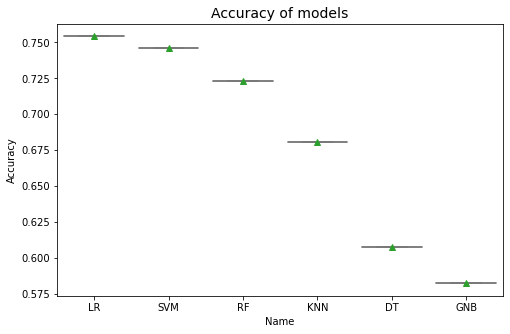

In [17]:
# Boxplot to see where each model accuracy performance are at
plt.figure(figsize=(8,5))
sns.boxplot(x='Name', y='Accuracy', 
            data=baseline_model_comparison, 
            color='lightblue', 
            showmeans=True)
plt.title("Accuracy of models", size=14);

#### Confusion Matrix & Classification Report

**Findings**:
> - Data Analyst: The probability of incorrect classification is higher for Data Analysts, as their job description overlaps with that of other positions in terms of the vocabulary used to describe it. Additionally, Data Analysts typically have less training data available.

> - Software Engineer: Model are able to identify this job role better as compared to others.


 LR


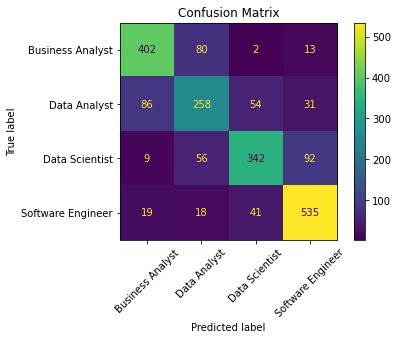


                    precision    recall  f1-score   support

 Business Analyst       0.78      0.81      0.79       497
     Data Analyst       0.63      0.60      0.61       429
   Data Scientist       0.78      0.69      0.73       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.75      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038


 SVM


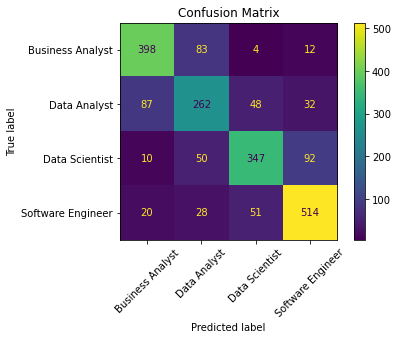


                    precision    recall  f1-score   support

 Business Analyst       0.77      0.80      0.79       497
     Data Analyst       0.62      0.61      0.62       429
   Data Scientist       0.77      0.70      0.73       499
Software Engineer       0.79      0.84      0.81       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038


 RF


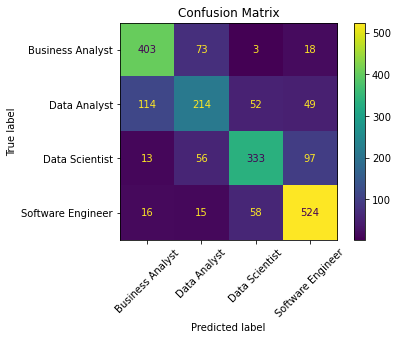


                    precision    recall  f1-score   support

 Business Analyst       0.74      0.81      0.77       497
     Data Analyst       0.60      0.50      0.54       429
   Data Scientist       0.75      0.67      0.70       499
Software Engineer       0.76      0.85      0.81       613

         accuracy                           0.72      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.72      0.72      2038


 KNN


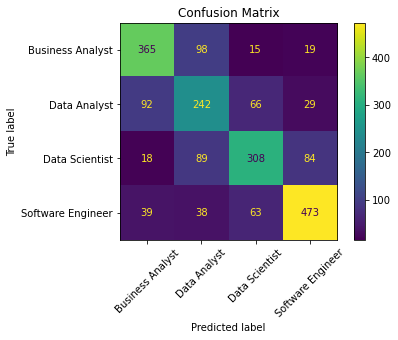


                    precision    recall  f1-score   support

 Business Analyst       0.71      0.73      0.72       497
     Data Analyst       0.52      0.56      0.54       429
   Data Scientist       0.68      0.62      0.65       499
Software Engineer       0.78      0.77      0.78       613

         accuracy                           0.68      2038
        macro avg       0.67      0.67      0.67      2038
     weighted avg       0.68      0.68      0.68      2038


 DT


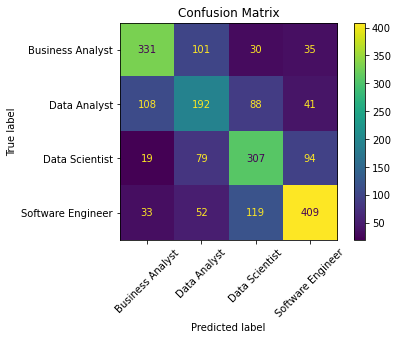


                    precision    recall  f1-score   support

 Business Analyst       0.67      0.67      0.67       497
     Data Analyst       0.45      0.45      0.45       429
   Data Scientist       0.56      0.62      0.59       499
Software Engineer       0.71      0.67      0.69       613

         accuracy                           0.61      2038
        macro avg       0.60      0.60      0.60      2038
     weighted avg       0.61      0.61      0.61      2038


 GNB


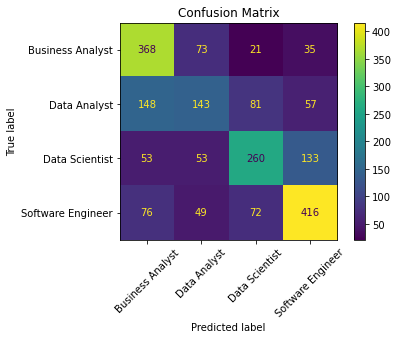


                    precision    recall  f1-score   support

 Business Analyst       0.57      0.74      0.64       497
     Data Analyst       0.45      0.33      0.38       429
   Data Scientist       0.60      0.52      0.56       499
Software Engineer       0.65      0.68      0.66       613

         accuracy                           0.58      2038
        macro avg       0.57      0.57      0.56      2038
     weighted avg       0.58      0.58      0.57      2038



In [18]:
# loop through each model
for i in baseline_model_comparison.index:
    # Show model name
    print("\n", baseline_model_comparison['Name'][i])
    
    # Plot Confusion matrix
    visual = baseline_model_comparison['CM Visual'][i]
    visual.plot()
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()
    
    # Show Classification Report
    print("\n", baseline_model_comparison['Classification Report'][i])

#### Model Performance Documenation on Data Cleaning

Version 1 Cleaning (Submitted) - Exclude Join Word + Exclude Spelling Error Removal **(Best Performance)**

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   LR | 0.754171 |  0.745726 | 0.742321 | 0.742792 | [[398, 85, 1, 13], [84, 262, 54, 29], [8, 59, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |  SVM | 0.745339 |  0.736137 | 0.735035 | 0.735009 | [[397, 82, 5, 13], [99, 257, 47, 26], [11, 52,... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |   RF | 0.716389 |  0.703187 | 0.700452 | 0.698013 | [[407, 67, 5, 18], [121, 201, 60, 47], [19, 47... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.681060 |  0.677078 | 0.674555 | 0.673374 | [[369, 94, 14, 20], [84, 266, 47, 32], [27, 95... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.632974 |  0.622780 | 0.624014 | 0.623005 | [[348, 102, 22, 25], [117, 201, 67, 44], [22, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.585868 |  0.603583 | 0.583937 | 0.583516 | [[245, 174, 30, 48], [70, 272, 52, 35], [21, 1... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |

Version 2 Cleaning - Include Join Words + Exclude Spelling Error Removal

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   LR | 0.753680 |  0.745132 | 0.742003 | 0.742233 | [[402, 81, 2, 12], [82, 263, 54, 30], [9, 64, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |  SVM | 0.745339 |  0.736082 | 0.734946 | 0.734924 | [[399, 83, 5, 10], [96, 257, 48, 28], [10, 53,... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |   RF | 0.720805 |  0.707959 | 0.705011 | 0.702774 | [[408, 67, 5, 17], [115, 205, 58, 51], [25, 47... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.679097 |  0.671997 | 0.671476 | 0.670410 | [[375, 90, 14, 18], [96, 247, 57, 29], [26, 88... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.627576 |  0.618813 | 0.618585 | 0.617943 | [[337, 92, 29, 39], [110, 200, 76, 43], [23, 7... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.623160 |  0.615525 | 0.616151 | 0.615115 | [[337, 106, 27, 27], [103, 206, 80, 40], [29, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |

Version 3 Cleaning - Exclude Join Words + Include Spelling Error Removal **(Choosen to perform)**

**Justification**

- **Taking into consideration again, I would consider that spelling error can include words that are like ("s" and "SpellingError" => Join Word), these are all words that do not bring any useful insights for Job Application.**
- If the amount of spelling error occur below 1000-2000 I would consider not removing it, but in my case there are 27217 unique misspelled words found, I **do not want to introduce too much spelling error to confuse my model**.
- Helps to reduce the size of the feature space and speed up the computation, it might still be worthwhile to remove more stop words.
- **Avoid introducing word with low occurrence like spelling error, would not help in identifying job role in building model.**
- The model is just affected by a little as low as 0.01 only.

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   LR | 0.753680 |  0.744861 | 0.741747 | 0.742226 | [[397, 85, 2, 13], [82, 260, 57, 30], [9, 56, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |  SVM | 0.745339 |  0.736547 | 0.734476 | 0.734746 | [[397, 81, 6, 13], [93, 257, 50, 29], [7, 54, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |   RF | 0.721786 |  0.708370 | 0.706248 | 0.704455 | [[403, 72, 3, 19], [116, 208, 58, 47], [17, 53... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.685476 |  0.678406 | 0.677349 | 0.676805 | [[369, 94, 15, 19], [88, 253, 57, 31], [23, 89... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.636899 |  0.627412 | 0.627076 | 0.626787 | [[352, 95, 31, 19], [99, 203, 91, 36], [23, 77... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.585868 |  0.571686 | 0.572268 | 0.566948 | [[363, 76, 16, 42], [145, 148, 78, 58], [51, 5... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |


Version 4 Cleaning - Include Join Words + Include Remove Spelling **(Worst Performance)**

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   LR | 0.751717 |  0.743578 | 0.740097 | 0.740524 | [[399, 84, 2, 12], [83, 262, 53, 31], [8, 62, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |  SVM | 0.737978 |  0.730021 | 0.727129 | 0.727705 | [[388, 90, 6, 13], [91, 257, 48, 33], [7, 57, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |   RF | 0.725711 |  0.713311 | 0.710450 | 0.709088 | [[406, 68, 5, 18], [109, 216, 58, 46], [17, 54... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.687439 |  0.679897 | 0.678916 | 0.678205 | [[372, 90, 16, 19], [96, 251, 55, 27], [23, 90... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.625123 |  0.618446 | 0.617303 | 0.617261 | [[336, 105, 26, 30], [99, 207, 79, 44], [24, 7... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.584887 |  0.569147 | 0.570710 | 0.565530 | [[359, 80, 18, 40], [142, 147, 83, 57], [48, 5... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |

**With that I have decided to add more stopwords E.g("use" which occur more than 1000 times) into removal of stopwords.**

It was found that there is a **slight improvement** in performance after removing it.

**Best Performance**

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   LR | 0.754171 |  0.745411 | 0.742095 | 0.742445 | [[402, 80, 2, 13], [86, 258, 54, 31], [9, 56, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |  SVM | 0.746320 |  0.738520 | 0.736354 | 0.736704 | [[398, 83, 4, 12], [87, 262, 48, 32], [10, 50,... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |   RF | 0.723258 |  0.711031 | 0.707962 | 0.706726 | [[403, 73, 3, 18], [114, 214, 52, 49], [13, 56... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.681060 |  0.672888 | 0.671840 | 0.671665 | [[365, 98, 15, 19], [92, 242, 66, 29], [18, 89... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.607949 |  0.599423 | 0.598997 | 0.598786 | [[331, 101, 30, 35], [108, 192, 88, 41], [19, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.582434 |  0.567073 | 0.568362 | 0.562042 | [[368, 73, 21, 35], [148, 143, 81, 57], [53, 5... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |

#### Model Performance Documenation on Feature Engineering

With ```ngram_range=(1, 2)``` or ```ngram_range=(2, 2)``` parameter assigned, it genereate a ```MemoryError: Unable to allocate 20.3 GiB for an array with shape (8152, 334896) and (8152, 324194) data type float64``` respectively.

In testing below I will conduct only unigram ```ngram_range=(1, 1)```

***Count Vectorizer + Unigram***

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   RF | 0.721786 |  0.710367 | 0.706432 | 0.704818 | [[402, 69, 4, 22], [117, 208, 54, 50], [20, 45... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |   LR | 0.694308 |  0.687014 | 0.686175 | 0.686488 | [[355, 113, 12, 17], [91, 251, 55, 32], [16, 5... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |  SVM | 0.685967 |  0.676583 | 0.676361 | 0.676397 | [[349, 106, 21, 21], [103, 233, 56, 37], [19, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.678116 |  0.668404 | 0.659933 | 0.659506 | [[358, 68, 7, 64], [94, 188, 81, 66], [17, 58,... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.633464 |  0.624975 | 0.625385 | 0.624650 | [[340, 106, 22, 29], [96, 205, 81, 47], [20, 6... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.585868 |  0.575501 | 0.570750 | 0.562887 | [[380, 63, 20, 34], [156, 137, 74, 62], [62, 4... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |


***Tfidf Vectorizer + Unigram*** - **(Best Performance)**

|   | Name | Accuracy | Precision |   Recall |       F1 |                                  Confusion Matrix |                                         CM Visual |      Classification Report |
|--:|-----:|---------:|----------:|---------:|---------:|--------------------------------------------------:|--------------------------------------------------:|---------------------------:|
| 0 |   LR | 0.754171 |  0.745411 | 0.742095 | 0.742445 | [[402, 80, 2, 13], [86, 258, 54, 31], [9, 56, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 1 |  SVM | 0.746320 |  0.738520 | 0.736354 | 0.736704 | [[398, 83, 4, 12], [87, 262, 48, 32], [10, 50,... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 2 |   RF | 0.723258 |  0.711031 | 0.707962 | 0.706726 | [[403, 73, 3, 18], [114, 214, 52, 49], [13, 56... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 3 |  KNN | 0.681060 |  0.672888 | 0.671840 | 0.671665 | [[365, 98, 15, 19], [92, 242, 66, 29], [18, 89... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 4 |   DT | 0.607949 |  0.599423 | 0.598997 | 0.598786 | [[331, 101, 30, 35], [108, 192, 88, 41], [19, ... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |
| 5 |  GNB | 0.582434 |  0.567073 | 0.568362 | 0.562042 | [[368, 73, 21, 35], [148, 143, 81, 57], [53, 5... | <sklearn.metrics._plot.confusion_matrix.Confus... | precision recall f1-sco... |


### Doc2Vec Model: Multi-Class Classification

- Doc2Vec are able to capture the semantic meaning of words and documents.
- Make comparison with TF-IDF model, find out which technique perform better in this classification task.

In [19]:
models = []
models.append(('SVM', LinearSVC(random_state=42)))
models.append(('LR', LogisticRegression(max_iter=150)))
models.append(('RF', RandomForestClassifier(random_state=42)))

In [20]:
def label_sentences(corpus, label_type):

    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [21]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                        random_state=42)

In [23]:
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [24]:
all_data

[TaggedDocument(words=['position', 'open', 'candidate', 'work', 'area', 'computer', 'science', 'engineering', 'interested', 'candidate', 'work', 'frontier', 'high', 'priority', 'area', 'system', 'include', 'computer', 'architecture', 'high', 'performance', 'compute', 'real', 'time', 'system', 'algorithms', 'language', 'software', 'interactive', 'compute', 'include', 'human', 'computer', 'interaction', 'visualization', 'high', 'quality', 'innovative', 'term', 'publish', 'tier', 'paper', 'secure', 'competitive', 'grant', 'supervise', 'personnel', 'conduct', 'competent', 'undergraduate', 'graduate', 'level', 'teach', 'include', 'academic', 'supervision', 'undergraduate', 'graduate', 'student', 'project', 'undertake', 'responsibly', 'assign', 'administrative', 'service', 'school', 'university'], tags=['Train_0']),
 TaggedDocument(words=['role', 'serve', 'production', 'monitoring', 'manager', 'responsible', 'implement', 'effective', 'control', 'monitor', 'report', 'ensure', 'adherence', 'en

In [25]:
## vector_size (int, optional) – Dimensionality of the feature vectors.
## negative (int, optional) – If > 0, negative sampling will be used, the int for negative 
## specifies how many “noise words” should be drawn (usually between 5-20)

## Test it with different vector size, there are no significant changes
## Tested it from range of 200 to 10000 with 1000 skip.
vector_size = 4000

model_dbow = Doc2Vec(dm=0, vector_size=vector_size, negative=5, min_count=15, alpha=0.065, min_alpha=0.065)

## Builds the vocabulary for the model
model_dbow.build_vocab([x for x in tqdm(all_data)])

# Initialize the model and train for 20 epochs
for epoch in range(20):
    ## Shuffle training data, and train it.
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
#     decrease the learning rate
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), vector_size, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), vector_size, 'Test')

100%|███████████████████████████████████████████████████████████████████████| 10190/10190 [00:00<00:00, 5081435.95it/s]
C:\Users\ZHANGX~1\AppData\Local\Temp/ipykernel_15828/1786841256.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


#### Doc2Vec Model Comparison 

In [26]:
print(train_vectors_dbow.shape)
train_vectors_dbow

(8152, 4000)


array([[-0.1128392 , -0.08880197, -0.07863693, ...,  0.05046706,
         0.08907765,  0.09099101],
       [ 0.07421558, -0.13995147, -0.08998927, ..., -0.08156846,
         0.04019198,  0.03776994],
       [ 0.00893812,  0.02964416,  0.07956395, ..., -0.17493834,
         0.04510987,  0.07905354],
       ...,
       [-0.00164966,  0.02923517, -0.06945152, ...,  0.09362012,
         0.18077512,  0.05406093],
       [-0.05075788, -0.05752391,  0.0376347 , ...,  0.12380259,
         0.08919954, -0.22549228],
       [-0.0080234 ,  0.10811562,  0.02675612, ..., -0.08561384,
        -0.0296021 , -0.10082567]])

In [27]:
print(test_vectors_dbow.shape)
test_vectors_dbow

(2038, 4000)


array([[ 0.04554197,  0.04593168,  0.09007238, ..., -0.02080668,
        -0.15989356,  0.15258579],
       [-0.07085115, -0.04310845,  0.02765058, ..., -0.17774159,
         0.14150232,  0.0003749 ],
       [ 0.01064724, -0.00697424,  0.01556042, ...,  0.01651776,
         0.06355797, -0.02601352],
       ...,
       [-0.0403833 ,  0.24214239, -0.16674399, ..., -0.16696928,
         0.02421232,  0.15794514],
       [ 0.06045349, -0.14695315,  0.18952437, ..., -0.00335623,
         0.11116304, -0.05113034],
       [ 0.05840202,  0.07273021, -0.0630602 , ...,  0.0476228 ,
        -0.04648329, -0.04556469]])

In [28]:
X_train = train_vectors_dbow
X_test = test_vectors_dbow

In [29]:
doc2vec_model_comparison = model_comparison()

C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
doc2vec_model_comparison

,Name,Accuracy,Precision,Recall,F1,Confusion Matrix,CM Visual,Classification Report
0,SVM,0.710010,0.696326,0.695258,0.694767,"[[372, 89, 15, 21], [94, 218, 76, 41], [21, 50...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
1,LR,0.708047,0.696366,0.695840,0.695910,"[[370, 91, 18, 18], [84, 236, 74, 35], [18, 66...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...
2,RF,0.681551,0.668388,0.661322,0.658253,"[[378, 71, 5, 43], [119, 173, 66, 71], [27, 51...",<sklearn.metrics._plot.confusion_matrix.Confus...,precision recall f1-sco...


Find that It does not perform as well as using TFIDF

### Select Top 3 Models: Baseline Model (TF-IDF)

***Why TF-IDF perform better than Doc2Vec for this task?***

Tfidf captures the importance of individual words in the text while Doc2Vec captures the overall meaning of the text. In job classification, the specific words used in the job titles and descriptions may be more important than the overall meaning of the text. Tfidf is a popular and effective method for text classification because it is relatively simple and efficient. 


1. Logistic Regression
2. Linear Support Vector Machine
3. Random Forest Classifier

### Feature Selection

- By conducting feature selection it can help to improve the performance of model by reducing the number of features that are irrelevant, noise towards the model. 
- By selecting a subset of the most informative and discriminative features, it  simplify the model and reduce overfitting, which can improve its generalization performance on new data.
- Diamension Reduction, which also reduce code runtime

In [31]:
def build_model(model, i):
    
    name = str(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cmVisual = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cmVisual.plot()
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()
    
    models_performance.append({'Model': name,
                               'Accuracy': accuracy_score(y_test, y_pred),
                               'Precision Score': precision_score(y_test, y_pred, average='macro'),
                               'Recall': recall_score(y_test, y_pred, average='macro'),
                               'F1': f1_score(y_test, y_pred, average='macro'),
                               'Features': i
                              })
    
    # Classification Report Data
    cr = classification_report(y_test, y_pred)
    print(cr)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    
    return model

#### Feature Selection - Chi Square

This technique will select the top k features with the highest chi-squared statistics. A **higher chi-squared value** is generally considered **better** for feature selection purposes because it suggests a **stronger association between a feature and the target variable**.

- Different model have different method to learn, therefore I will run a for loop to find the best amount of features for different models. 

- Best performance in each model algorithm will be selected for further modelling process

In [32]:
models_performance = []

10000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 10000)
The size of feature selected dataset:  (2038, 10000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


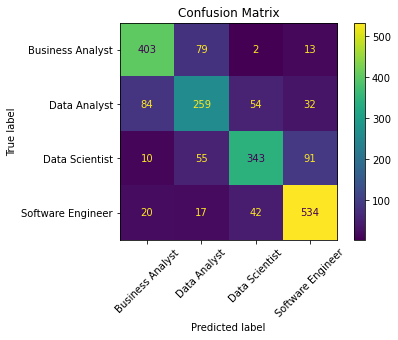

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.81      0.79       497
     Data Analyst       0.63      0.60      0.62       429
   Data Scientist       0.78      0.69      0.73       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.76      2038
        macro avg       0.75      0.74      0.74      2038
     weighted avg       0.75      0.76      0.75      2038

Accuracy:  0.7551521099116781
9000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 9000)
The size of feature selected dataset:  (2038, 9000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


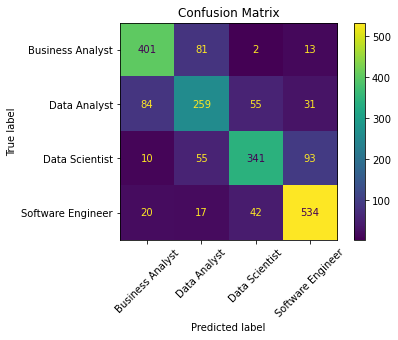

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.81      0.79       497
     Data Analyst       0.63      0.60      0.62       429
   Data Scientist       0.78      0.68      0.73       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.753189401373896
8000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 8000)
The size of feature selected dataset:  (2038, 8000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


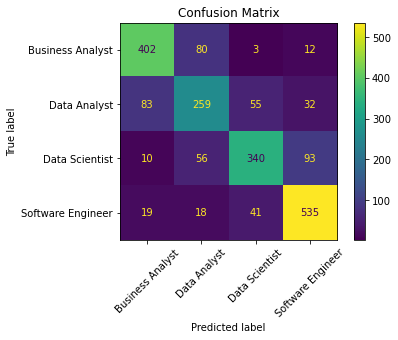

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.81      0.80       497
     Data Analyst       0.63      0.60      0.62       429
   Data Scientist       0.77      0.68      0.72       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7536800785083415
7000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 7000)
The size of feature selected dataset:  (2038, 7000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


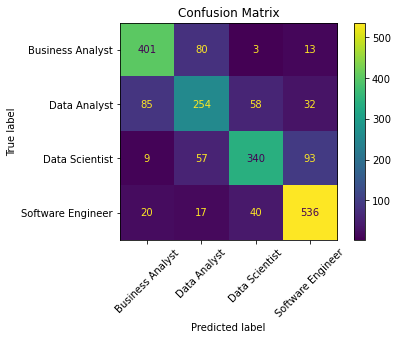

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.81      0.79       497
     Data Analyst       0.62      0.59      0.61       429
   Data Scientist       0.77      0.68      0.72       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7512266928361139
6000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 6000)
The size of feature selected dataset:  (2038, 6000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


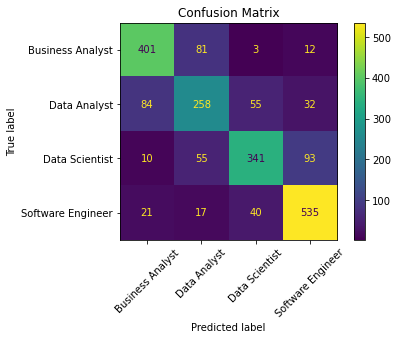

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.81      0.79       497
     Data Analyst       0.63      0.60      0.61       429
   Data Scientist       0.78      0.68      0.73       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.753189401373896
5000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 5000)
The size of feature selected dataset:  (2038, 5000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


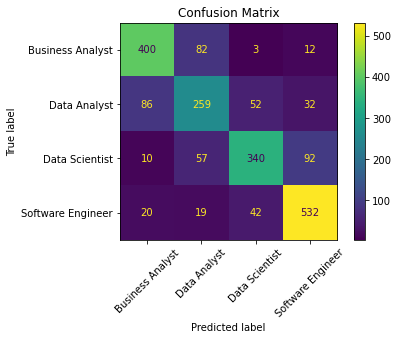

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.80      0.79       497
     Data Analyst       0.62      0.60      0.61       429
   Data Scientist       0.78      0.68      0.73       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7512266928361139
4000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 4000)
The size of feature selected dataset:  (2038, 4000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


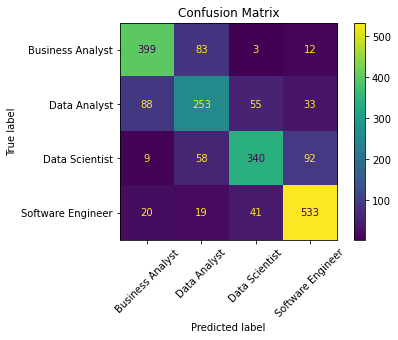

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.80      0.79       497
     Data Analyst       0.61      0.59      0.60       429
   Data Scientist       0.77      0.68      0.72       499
Software Engineer       0.80      0.87      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7482826300294406
3000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 3000)
The size of feature selected dataset:  (2038, 3000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


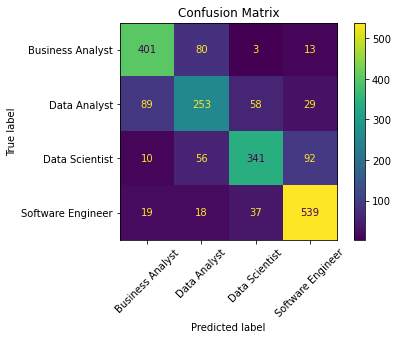

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.81      0.79       497
     Data Analyst       0.62      0.59      0.61       429
   Data Scientist       0.78      0.68      0.73       499
Software Engineer       0.80      0.88      0.84       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7526987242394504
2000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 2000)
The size of feature selected dataset:  (2038, 2000)


C:\Users\Zhang Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


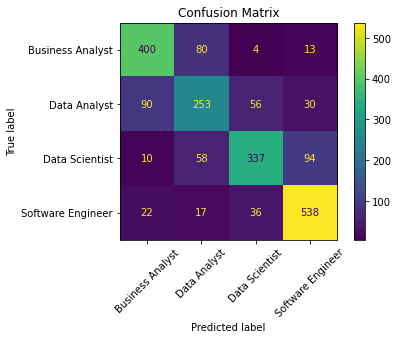

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.80      0.79       497
     Data Analyst       0.62      0.59      0.60       429
   Data Scientist       0.78      0.68      0.72       499
Software Engineer       0.80      0.88      0.84       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7497546614327772


In [33]:
for i in range(10000, 1000, -1000):
    print(i, "Features")

    X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

    # With testing of k value in range of 1000-max(10702+) decrease 1000 per test
    selector = SelectKBest(score_func=chi2, k=i)
    selector.fit(X_train, y_train)
    
    # Transform vectorized data into new fitted feature selected data for diamension reduction.
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    print("The size of feature selected dataset: ",X_train.shape)
    print("The size of feature selected dataset: ",X_test.shape)
    
    model = LogisticRegression()

    build_model(model, i)

10000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 10000)
The size of feature selected dataset:  (2038, 10000)


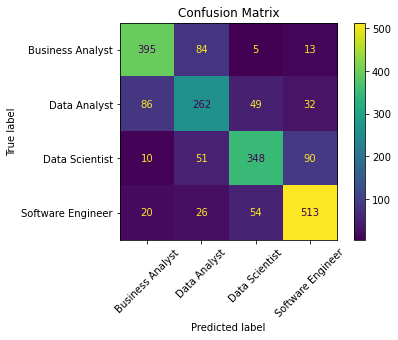

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.79      0.78       497
     Data Analyst       0.62      0.61      0.62       429
   Data Scientist       0.76      0.70      0.73       499
Software Engineer       0.79      0.84      0.81       613

         accuracy                           0.74      2038
        macro avg       0.74      0.73      0.74      2038
     weighted avg       0.74      0.74      0.74      2038

Accuracy:  0.7448478900883219
9000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 9000)
The size of feature selected dataset:  (2038, 9000)


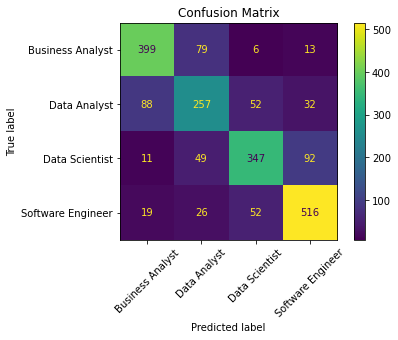

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.80      0.79       497
     Data Analyst       0.63      0.60      0.61       429
   Data Scientist       0.76      0.70      0.73       499
Software Engineer       0.79      0.84      0.82       613

         accuracy                           0.75      2038
        macro avg       0.74      0.73      0.73      2038
     weighted avg       0.74      0.75      0.74      2038

Accuracy:  0.7453385672227674
8000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 8000)
The size of feature selected dataset:  (2038, 8000)


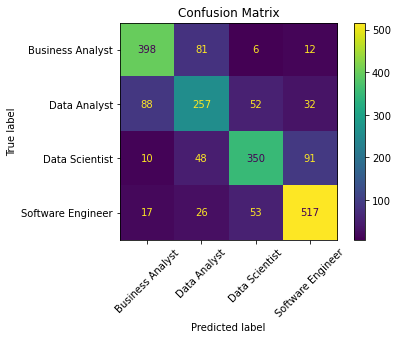

                   precision    recall  f1-score   support

 Business Analyst       0.78      0.80      0.79       497
     Data Analyst       0.62      0.60      0.61       429
   Data Scientist       0.76      0.70      0.73       499
Software Engineer       0.79      0.84      0.82       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.74      0.75      0.75      2038

Accuracy:  0.746810598626104
7000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 7000)
The size of feature selected dataset:  (2038, 7000)


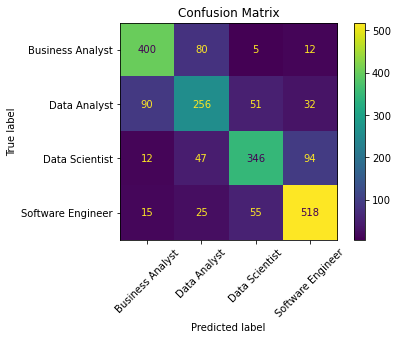

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.80      0.79       497
     Data Analyst       0.63      0.60      0.61       429
   Data Scientist       0.76      0.69      0.72       499
Software Engineer       0.79      0.85      0.82       613

         accuracy                           0.75      2038
        macro avg       0.74      0.73      0.74      2038
     weighted avg       0.74      0.75      0.74      2038

Accuracy:  0.745829244357213
6000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 6000)
The size of feature selected dataset:  (2038, 6000)


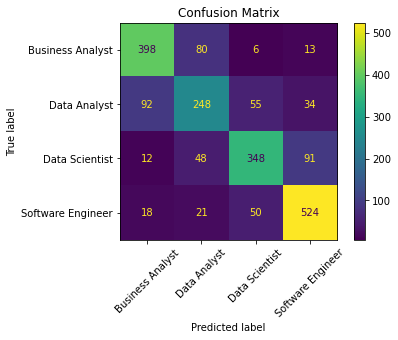

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.80      0.78       497
     Data Analyst       0.62      0.58      0.60       429
   Data Scientist       0.76      0.70      0.73       499
Software Engineer       0.79      0.85      0.82       613

         accuracy                           0.74      2038
        macro avg       0.73      0.73      0.73      2038
     weighted avg       0.74      0.74      0.74      2038

Accuracy:  0.7448478900883219
5000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 5000)
The size of feature selected dataset:  (2038, 5000)


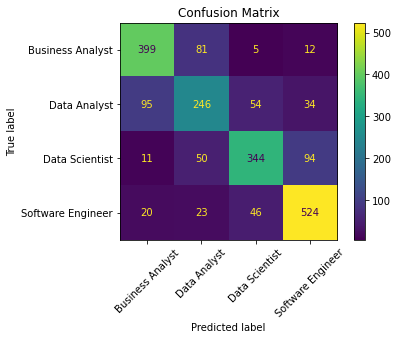

                   precision    recall  f1-score   support

 Business Analyst       0.76      0.80      0.78       497
     Data Analyst       0.61      0.57      0.59       429
   Data Scientist       0.77      0.69      0.73       499
Software Engineer       0.79      0.85      0.82       613

         accuracy                           0.74      2038
        macro avg       0.73      0.73      0.73      2038
     weighted avg       0.74      0.74      0.74      2038

Accuracy:  0.7423945044160942
4000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 4000)
The size of feature selected dataset:  (2038, 4000)


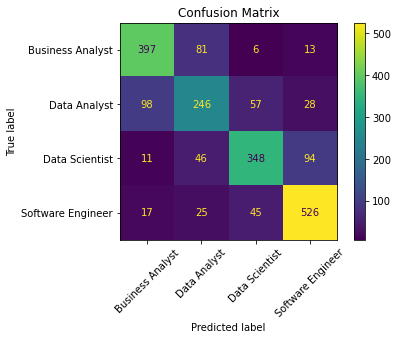

                   precision    recall  f1-score   support

 Business Analyst       0.76      0.80      0.78       497
     Data Analyst       0.62      0.57      0.59       429
   Data Scientist       0.76      0.70      0.73       499
Software Engineer       0.80      0.86      0.83       613

         accuracy                           0.74      2038
        macro avg       0.73      0.73      0.73      2038
     weighted avg       0.74      0.74      0.74      2038

Accuracy:  0.7443572129538764
3000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 3000)
The size of feature selected dataset:  (2038, 3000)


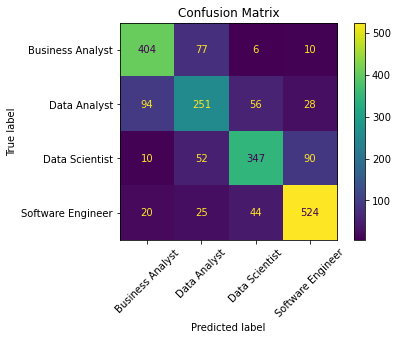

                   precision    recall  f1-score   support

 Business Analyst       0.77      0.81      0.79       497
     Data Analyst       0.62      0.59      0.60       429
   Data Scientist       0.77      0.70      0.73       499
Software Engineer       0.80      0.85      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7487733071638861
2000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 2000)
The size of feature selected dataset:  (2038, 2000)


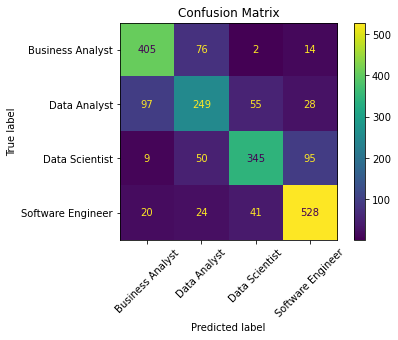

                   precision    recall  f1-score   support

 Business Analyst       0.76      0.81      0.79       497
     Data Analyst       0.62      0.58      0.60       429
   Data Scientist       0.78      0.69      0.73       499
Software Engineer       0.79      0.86      0.83       613

         accuracy                           0.75      2038
        macro avg       0.74      0.74      0.74      2038
     weighted avg       0.75      0.75      0.75      2038

Accuracy:  0.7492639842983317


In [34]:
for i in range(10000, 1000, -1000):
    print(i, "Features")
    
    X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

    # With testing of k value in range of 1000-max(10702) decrease 1000 per test
    # With k=9000, it return a small improvement.
    selector = SelectKBest(score_func=chi2, k=i)
    selector.fit(X_train, y_train)
    
    # Transform vectorized data into new fitted feature selected data for diamension reduction.
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    print("The size of feature selected dataset: ",X_train.shape)
    print("The size of feature selected dataset: ",X_test.shape)

    model = LinearSVC(random_state=42)

    build_model(model, i)

10000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 10000)
The size of feature selected dataset:  (2038, 10000)


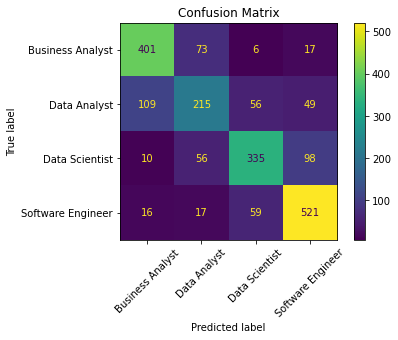

                   precision    recall  f1-score   support

 Business Analyst       0.75      0.81      0.78       497
     Data Analyst       0.60      0.50      0.54       429
   Data Scientist       0.73      0.67      0.70       499
Software Engineer       0.76      0.85      0.80       613

         accuracy                           0.72      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.72      0.72      2038

Accuracy:  0.7222767419038273
9000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 9000)
The size of feature selected dataset:  (2038, 9000)


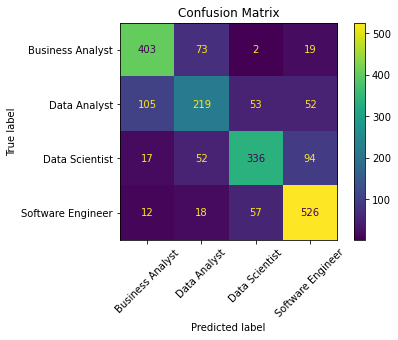

                   precision    recall  f1-score   support

 Business Analyst       0.75      0.81      0.78       497
     Data Analyst       0.60      0.51      0.55       429
   Data Scientist       0.75      0.67      0.71       499
Software Engineer       0.76      0.86      0.81       613

         accuracy                           0.73      2038
        macro avg       0.72      0.71      0.71      2038
     weighted avg       0.72      0.73      0.72      2038

Accuracy:  0.7281648675171737
8000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 8000)
The size of feature selected dataset:  (2038, 8000)


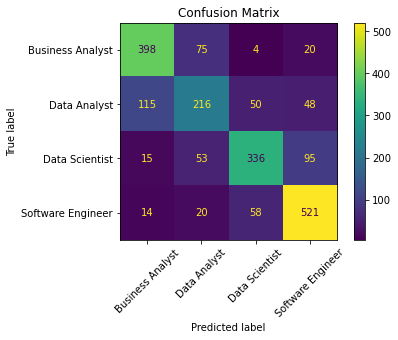

                   precision    recall  f1-score   support

 Business Analyst       0.73      0.80      0.77       497
     Data Analyst       0.59      0.50      0.54       429
   Data Scientist       0.75      0.67      0.71       499
Software Engineer       0.76      0.85      0.80       613

         accuracy                           0.72      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.72      0.72      2038

Accuracy:  0.7217860647693818
7000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 7000)
The size of feature selected dataset:  (2038, 7000)


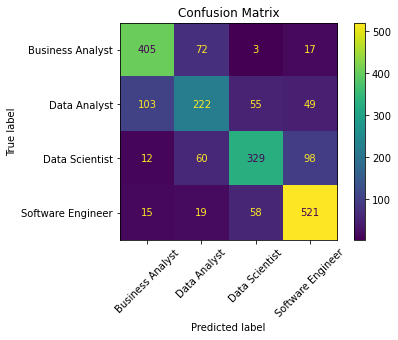

                   precision    recall  f1-score   support

 Business Analyst       0.76      0.81      0.78       497
     Data Analyst       0.60      0.52      0.55       429
   Data Scientist       0.74      0.66      0.70       499
Software Engineer       0.76      0.85      0.80       613

         accuracy                           0.72      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.72      0.72      2038

Accuracy:  0.7247301275760549
6000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 6000)
The size of feature selected dataset:  (2038, 6000)


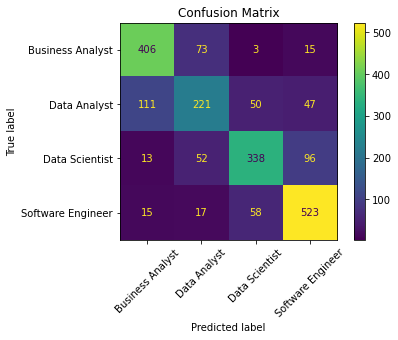

                   precision    recall  f1-score   support

 Business Analyst       0.74      0.82      0.78       497
     Data Analyst       0.61      0.52      0.56       429
   Data Scientist       0.75      0.68      0.71       499
Software Engineer       0.77      0.85      0.81       613

         accuracy                           0.73      2038
        macro avg       0.72      0.72      0.71      2038
     weighted avg       0.73      0.73      0.73      2038

Accuracy:  0.7301275760549558
5000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 5000)
The size of feature selected dataset:  (2038, 5000)


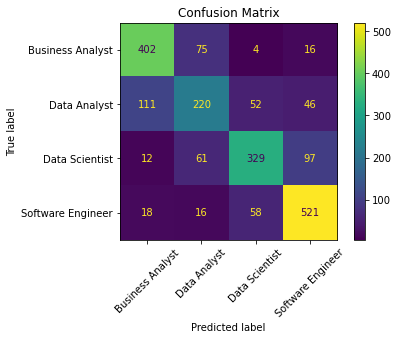

                   precision    recall  f1-score   support

 Business Analyst       0.74      0.81      0.77       497
     Data Analyst       0.59      0.51      0.55       429
   Data Scientist       0.74      0.66      0.70       499
Software Engineer       0.77      0.85      0.81       613

         accuracy                           0.72      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.72      0.72      2038

Accuracy:  0.7222767419038273
4000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 4000)
The size of feature selected dataset:  (2038, 4000)


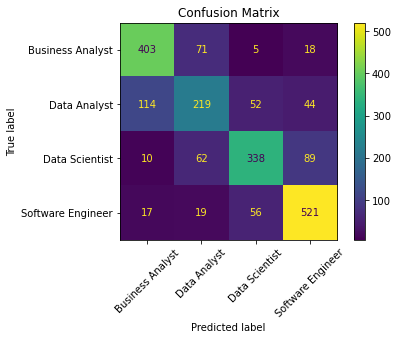

                   precision    recall  f1-score   support

 Business Analyst       0.74      0.81      0.77       497
     Data Analyst       0.59      0.51      0.55       429
   Data Scientist       0.75      0.68      0.71       499
Software Engineer       0.78      0.85      0.81       613

         accuracy                           0.73      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.73      0.72      2038

Accuracy:  0.7266928361138371
3000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 3000)
The size of feature selected dataset:  (2038, 3000)


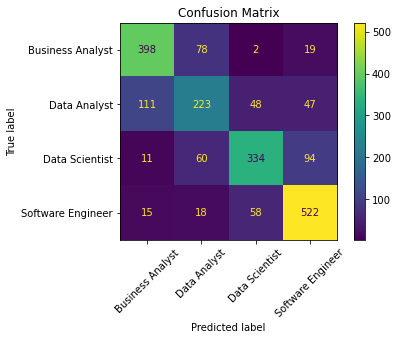

                   precision    recall  f1-score   support

 Business Analyst       0.74      0.80      0.77       497
     Data Analyst       0.59      0.52      0.55       429
   Data Scientist       0.76      0.67      0.71       499
Software Engineer       0.77      0.85      0.81       613

         accuracy                           0.72      2038
        macro avg       0.71      0.71      0.71      2038
     weighted avg       0.72      0.72      0.72      2038

Accuracy:  0.7247301275760549
2000 Features
The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 2000)
The size of feature selected dataset:  (2038, 2000)


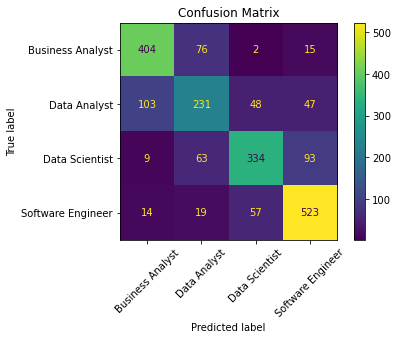

                   precision    recall  f1-score   support

 Business Analyst       0.76      0.81      0.79       497
     Data Analyst       0.59      0.54      0.56       429
   Data Scientist       0.76      0.67      0.71       499
Software Engineer       0.77      0.85      0.81       613

         accuracy                           0.73      2038
        macro avg       0.72      0.72      0.72      2038
     weighted avg       0.73      0.73      0.73      2038

Accuracy:  0.732090284592738


In [35]:
for i in range(10000, 1000, -1000):
    print(i, "Features")

    X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

    # With testing of k value in range of 1000-max(10702+) decrease 1000 per test
    selector = SelectKBest(score_func=chi2, k=i)
    selector.fit(X_train, y_train)
    
    # Transform vectorized data into new fitted feature selected data for diamension reduction.
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    print("The size of feature selected dataset: ",X_train.shape)
    print("The size of feature selected dataset: ",X_test.shape)

    model = RandomForestClassifier(random_state=42)

    build_model(model, i)

In [36]:
pd.DataFrame(models_performance)

,Model,Accuracy,Precision Score,Recall,F1,Features
0,LogisticRegression(),0.755152,0.746499,0.743274,0.743621,10000
1,LogisticRegression(),0.753189,0.744527,0.741266,0.741626,9000
2,LogisticRegression(),0.753680,0.744960,0.741676,0.742021,8000
3,LogisticRegression(),0.751227,0.741854,0.738667,0.738942,7000
4,LogisticRegression(),0.753189,0.744441,0.741091,0.741439,6000
5,LogisticRegression(),0.751227,0.742684,0.739446,0.739781,5000
6,LogisticRegression(),0.748283,0.738964,0.735854,0.736130,4000
7,LogisticRegression(),0.752699,0.742980,0.739808,0.739993,3000
8,LogisticRegression(),0.749755,0.740427,0.736894,0.737051,2000
9,LinearSVC(random_state=42),0.744848,0.736801,0.734938,0.735297,10000


#### Search for Best Features selected for each model

Found that LogisticRegression still perform the best.

In [37]:
def get_best_accuracy(data):
    models = set([d['Model'] for d in data])
    result = []
    for model in models:
        filtered_data = [d for d in data if d['Model'] == model]
        best_accuracy = max([d['Accuracy'] for d in filtered_data])
        best_model = [d for d in filtered_data if d['Accuracy'] == best_accuracy][0]
        result.append(best_model)
    return result

selected_features = pd.DataFrame(get_best_accuracy(models_performance)).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
selected_features

,Model,Accuracy,Precision Score,Recall,F1,Features
0,LogisticRegression(),0.755152,0.746499,0.743274,0.743621,10000
1,LinearSVC(random_state=42),0.749264,0.739885,0.737007,0.737041,2000
2,RandomForestClassifier(random_state=42),0.732090,0.721213,0.718465,0.718103,2000


### Logistic Regression (Best Performance)

#### Original Multi-Class Text Classification
- With ROC, AUC
- With Multi-Class Classification Probability

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)


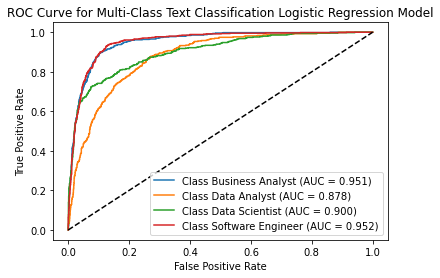

Accuracy:  0.754170755642787


,Role,Business Analyst,Data Analyst,Data Scientist,Software Engineer
0,Data Scientist,0.006159,0.018101,0.965336,0.010405
1,Data Analyst,0.351840,0.547857,0.087082,0.013221
2,Business Analyst,0.350367,0.161490,0.173351,0.314792
3,Data Scientist,0.013773,0.288694,0.605634,0.091899
4,Data Analyst,0.981647,0.015365,0.002150,0.000837


In [38]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

model = LogisticRegression(max_iter=150)
model.fit(X_train, y_train)

# Predict Label
y_pred = model.predict(X_test)

# Retrieve probability of each class
y_prob = model.predict_proba(X_test)

classes = model.classes_

# Calculate the ROC curve for each class
for i in range(len(classes)):
    y_test_bin = np.where(y_test == classes[i], 1, 0)
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob[:, i], pos_label=1)
    auc = roc_auc_score(y_test_bin, y_prob[:, i])
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.3f})".format(classes[i], auc))

plt.plot([0, 1], [0, 1], "k--")

# Set labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Text Classification Logistic Regression Model")
plt.legend(loc="lower right")
# Show the plot
plt.show()

# View Multi-Class Classification Probability
prob_pred_df = pd.DataFrame(y_prob, columns=classes)
prob_pred_df = pd.concat([y_test.reset_index(drop=True), prob_pred_df], axis=1)

print('Accuracy: ', accuracy_score(y_test, y_pred))

prob_pred_df.head()

#### Feature Selected Multi-Class Text Classification
- With ROC, AUC
- With Multi-Class Classification Probability
- Testing it again from 10000-10700 found that with k=10100 it perform best.

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 10100)
The size of feature selected dataset:  (2038, 10100)


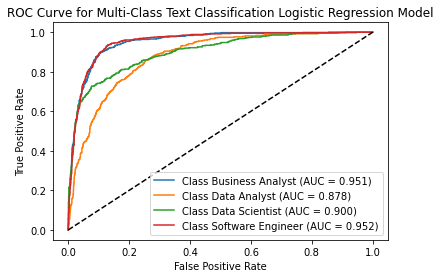

Accuracy:  0.7561334641805691


,Role,Business Analyst,Data Analyst,Data Scientist,Software Engineer
0,Data Scientist,0.006069,0.017249,0.966517,0.010166
1,Data Analyst,0.352532,0.545800,0.088202,0.013466
2,Business Analyst,0.347480,0.161252,0.174741,0.316527
3,Data Scientist,0.014299,0.282993,0.606316,0.096392
4,Data Analyst,0.981647,0.015278,0.002219,0.000856


In [39]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

# With testing of k value in range of 1000-max(10700+) increase 1000 per test
selector = SelectKBest(score_func=chi2, k=10100)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

print("The size of feature selected dataset: ",X_train.shape)
print("The size of feature selected dataset: ",X_test.shape)

model = LogisticRegression(max_iter=150)

model.fit(X_train, y_train)

# Predict Label
y_pred = model.predict(X_test)

# Retrieve probability of each class
y_prob = model.predict_proba(X_test)
classes = model.classes_

# Calculate the ROC curve for each class
for i in range(len(classes)):
    y_test_bin = np.where(y_test == classes[i], 1, 0)
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob[:, i], pos_label=1)
    auc = roc_auc_score(y_test_bin, y_prob[:, i])
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.3f})".format(classes[i], auc))

plt.plot([0, 1], [0, 1], "k--")

# Set labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Text Classification Logistic Regression Model")
plt.legend(loc="lower right")
# Show the plot
plt.show()

# View Multi-Class Classification Probability
prob_pred_df = pd.DataFrame(y_prob, columns=classes)
prob_pred_df = pd.concat([y_test.reset_index(drop=True), prob_pred_df], axis=1)

print('Accuracy: ', accuracy_score(y_test, y_pred))

prob_pred_df.head()

#### LinearSVC do not have the attribute of predict_proba. (Not Conducted)

### RandomForest

#### Original Multi-Class Text Classification
- With ROC, AUC
- With Multi-Class Classification Probability

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)


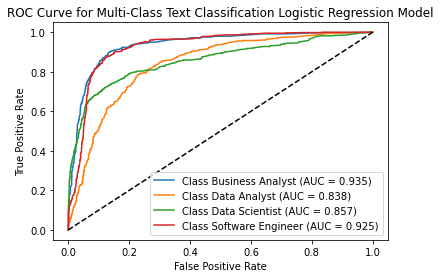

Accuracy:  0.7232580961727183


,Role,Business Analyst,Data Analyst,Data Scientist,Software Engineer
0,Data Scientist,0.040000,0.200000,0.627500,0.132500
1,Data Analyst,0.430000,0.480000,0.075000,0.015000
2,Business Analyst,0.340000,0.245000,0.035833,0.379167
3,Data Scientist,0.105000,0.235000,0.480000,0.180000
4,Data Analyst,0.713333,0.193333,0.040000,0.053333


In [40]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

# Predict Label
y_pred = model.predict(X_test)

# Retrieve probability of each class
y_prob = model.predict_proba(X_test)

classes = model.classes_

# Calculate the ROC curve for each class
for i in range(len(classes)):
    y_test_bin = np.where(y_test == classes[i], 1, 0)
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob[:, i], pos_label=1)
    auc = roc_auc_score(y_test_bin, y_prob[:, i])
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.3f})".format(classes[i], auc))

plt.plot([0, 1], [0, 1], "k--")

# Set labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Text Classification Logistic Regression Model")
plt.legend(loc="lower right")
# Show the plot
plt.show()

# View Multi-Class Classification Probability
prob_pred_df = pd.DataFrame(y_prob, columns=classes)
prob_pred_df = pd.concat([y_test.reset_index(drop=True), prob_pred_df], axis=1)

print('Accuracy: ', accuracy_score(y_test, y_pred))

prob_pred_df.head()

#### Feature Selected Multi-Class Text Classification
- With ROC, AUC
- With Multi-Class Classification Probability

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 2000)
The size of feature selected dataset:  (2038, 2000)


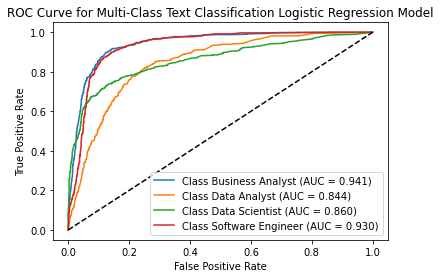

Accuracy:  0.732090284592738


,Role,Business Analyst,Data Analyst,Data Scientist,Software Engineer
0,Data Scientist,0.020000,0.155000,0.717667,0.107333
1,Data Analyst,0.390000,0.480000,0.130000,0.000000
2,Business Analyst,0.358333,0.158333,0.135000,0.348333
3,Data Scientist,0.050000,0.280000,0.565000,0.105000
4,Data Analyst,0.818000,0.122000,0.050000,0.010000


In [41]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

# With testing of k value in range of 1000-max(10700+) increase 1000 per test
selector = SelectKBest(score_func=chi2, k=2000)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

print("The size of feature selected dataset: ",X_train.shape)
print("The size of feature selected dataset: ",X_test.shape)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

# Predict Label
y_pred = model.predict(X_test)

# Retrieve probability of each class
y_prob = model.predict_proba(X_test)

# Get label in default order
classes = model.classes_

# Calculate the ROC curve for each class
for i in range(len(classes)):
    y_test_bin = np.where(y_test == classes[i], 1, 0)
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob[:, i], pos_label=1)
    auc = roc_auc_score(y_test_bin, y_prob[:, i])
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.3f})".format(classes[i], auc))

plt.plot([0, 1], [0, 1], "k--")

# Set labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Text Classification Logistic Regression Model")
plt.legend(loc="lower right")
# Show the plot
plt.show()

# View Multi-Class Classification Probability
prob_pred_df = pd.DataFrame(y_prob, columns=classes)
prob_pred_df = pd.concat([y_test.reset_index(drop=True), prob_pred_df], axis=1)

print('Accuracy: ', accuracy_score(y_test, y_pred))

prob_pred_df.head()

### Feature Selected

This portion is to prepare data for hyperparameter tuning with the features selected.

Out of all the models available, only Logistic Regression and LinearSVC will undergo hyperparameter tuning. These two models have the closest and highest scoring, and thus, are the top two models selected for further analysis.

##### For Logistic Regression

In [42]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

# Select top 10100 Features
selector = SelectKBest(chi2, k=10100)
selector.fit(X_train, y_train)

# top_k_indices = selector.get_support(indices=True)

# # Update X train and test
# X_train_lr = X_train[:, top_k_indices]
# X_test_lr = X_test[:, top_k_indices]

X_train_lr = selector.transform(X_train)
X_test_lr = selector.transform(X_test)
print("The size of feature selected dataset: ",X_train_lr.shape)
print("The size of feature selected dataset: ",X_test_lr.shape)

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 10100)
The size of feature selected dataset:  (2038, 10100)


##### For LinearSVC 

In [43]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

# Select top 2000 Features
selector = SelectKBest(chi2, k=2000)
selector.fit(X_train, y_train)

# top_k_indices = selector.get_support(indices=True)

# # Update X train and test
# X_train_svm = X_train[:, top_k_indices]
# X_test_svm = X_test[:, top_k_indices]

X_train_svm = selector.transform(X_train)
X_test_svm = selector.transform(X_test)

print("The size of feature selected dataset: ",X_train_svm.shape)
print("The size of feature selected dataset: ",X_test_svm.shape)

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)
The size of feature selected dataset:  (8152, 2000)
The size of feature selected dataset:  (2038, 2000)


### Model Selection with Hyperparameter Tuning

- Picked the top 2 models above for further hyper-tuning.

- Only the best performance model will be used for model testing.

In [44]:
def test_model(model):
    
    name = str(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cmVisual = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cmVisual.plot()
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()
    
    models_performance.append({'Model': name,
                               'Accuracy': accuracy_score(y_test, y_pred),
                               'Precision Score': precision_score(y_test, y_pred, average='macro'),
                               'Recall': recall_score(y_test, y_pred, average='macro'),
                               'F1': f1_score(y_test, y_pred, average='macro')
                              })
    
    # Classification Report Data
    cr = classification_report(y_test, y_pred)
    print(cr)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    
    return model

**Top 2 models will be selected for further parameter tuning with features selected**

In [45]:
models_performance = []

In [46]:
X_train, X_test, y_train, y_test = split_train_test_vect(X, y)

The size of original dataset:  (10190,)
The size of traning dataset:  (8152,)
The size of testing dataset:  (2038,)
The diemnsions of training set:  (8152, 10702)
The diemnsions of testing set:  (2038, 10702)


#### Logistic Regression

In [47]:
X_train = X_train_lr
X_test = X_test_lr

‘liblinear’ cannot be used to one-versus-rest schemes.

In [ ]:
parameters = {'penalty': ['l1', 'l2'],
              'C': [0.5, 0.7, 0.9, 1, 1.2, 1.5],
              'max_iter': [150, 200]
             }

# cv parameter can be used for number of folds to use for cross-validation.
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


##### Further Testing

From GridSearchCV
~~~Python
Best: C= 0.7, max_iter= 150, penalty= 'l2'
~~~

Through multiple testing in the C value, found that 1.1 is best without cross validation.

In [ ]:
test_model(LogisticRegression(C= 1.1, max_iter= 150, penalty= 'l2'))

#### LinearSVC

In [ ]:
X_train = X_train_svm
X_test = X_test_svm

In [ ]:
parameters = {'C': [0.1, 0.5, 0.7, 1, 1.2, 1,4, 2], 
              'loss': ['hinge', 'squared_hinge'], 
              'penalty': ['l1', 'l2']}

# cv parameter can be used for number of folds to use for cross-validation.
grid_search = GridSearchCV(LinearSVC(random_state=42), parameters, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

~~~Python
Best: C= 1, loss= 'hinge', penalty= 'l2', random_state=42
~~~

In [ ]:
test_model(LinearSVC(C=1, loss='hinge',random_state=42))

## Evaluation

### Metrics

These are metrics that I look for to decide on best model.
- **Accuracy:** The proportion of correctly classified instances out of all instances
- **Precision:** The proportion of true positives (correctly classified positive instances) out of all positive predictions
- **Recall:** The proportion of true positives out of all actual positive instances
- **F1 score:** The harmonic mean of precision and recall, with equal weight given to both metrics. Like an Average.

### Result

#### Best Classification Model: Logistic Regression, with 10100 Features Selected & Using TF-IDF

***Why Logistic Regression but not Linear Support Vector Machine?***

Based on the evaluation metrics provided, the logistic regression model performs slightly better than the LinearSVC model for the job classification task. This is indicated by the higher precision, recall, and f1-score values for the logistic regression model across all job categories, as well as the higher overall accuracy score.

~~~Python
LogisticRegression(C= 1.1, max_iter= 150, penalty= 'l2')
~~~


### Model Testing

1) **Save and Load Trained Machine Learning Model (Model, Vectorizer)**

- Easier deployment of the model and quicker testing of new data without having to retrain the model from scratch every time.

Example:
~~~Python
import pickle

# Saving
with open(lr_file, 'wb') as f1:
    pickle.dump(model, f1)
    
# Loading    
with open(lr_file, 'rb') as f:
    model = pickle.load(f)
~~~




2) **Simple Text Pre Processing**

Text can be cleaned using similar methods to those used in text modeling. This results in a uniform format for the text data, making it easier for the machine to learn from and produce better results.

- Lowercase
- Remove Punctuation
- Word Tokenize
- Remove Stopwords
- Lemmatize Text


3) **Test Model**
- Generate Label (most suitable role based on text)
- Generate Label Probability (For each of the job role that the text is classified)
    - Can be used to make decision on other suitable job role as well
    
4) **Conclusion**

### Best Model

In [ ]:
# Use original train-test split function from sklearn 
# to show each step by step.
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=42)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(ngram_range = (1,1))
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
print(vectorizer)
print(X_train.shape)
print(X_test.shape)

# Select first k features
selector = SelectKBest(chi2, k=10100)
selector.fit(X_train, y_train)
print(selector)

# Transform & use feature selected
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

print(X_train.shape)
print(X_test.shape)

# Modelling
model = LogisticRegression(C= 1.1, max_iter= 150)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmVisual = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cmVisual.plot()
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Classification Report Data
cr = classification_report(y_test, y_pred)
print(cr)

print('Accuracy: ', accuracy_score(y_test, y_pred))

In [ ]:
model

### Model Testing

#### Save Model, Vectorizer & Selector

In [ ]:
lr_file = "lr.pkl"

v_file = "vectorizer.pkl"

s_file = "selected_feature.pkl"

with open(lr_file, 'wb') as f1:
    pickle.dump(model, f1)

with open(v_file, 'wb') as f1:
    pickle.dump(vectorizer, f1)
    
with open(s_file, 'wb') as f1:
    pickle.dump(selector, f1)

#### Load Model, Vectorizer & Selector

In [ ]:
with open(lr_file, 'rb') as f:
    model = pickle.load(f)
    
    
with open(v_file, 'rb') as f:
    vectorizer = pickle.load(f)
    
with open(s_file, 'rb') as f:
    selector = pickle.load(f)

#### Simple Text Pre Processing

In [ ]:
def lemmatizing(cleaned_arr):
    lemmatizer = WordNetLemmatizer()
    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    pos_tagged = nltk.pos_tag(cleaned_arr)
    
    # wordnet_tagged return something like [('wanted', 'v'), ('love', 'n'), ('even', 'r')]
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as it is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token to lemmatize the matched tagging with the word
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence

In [ ]:
# Text Preprocessing Function
def text_preprocessing(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    lemmatized_text = lemmatizing(words)
    
    return lemmatized_text

#### Test Model

In [ ]:
# Preprocess text
text_processed = text_preprocessing('Tableau or Power BI')

print(text_processed)

# Vectorize text
new_text_vector = vectorizer.transform([text_processed])
print("\n  Original Feature:\n", new_text_vector)
print("Original Features:", vectorizer.inverse_transform(new_text_vector))

# Transform vectorized data with feature selected fitted data
new_text_vector = selector.transform(new_text_vector)
print("\n New Feature Selected:\n",new_text_vector)

# Job Predicted
predicted_label = (model.predict(new_text_vector))[0]
predicted_label

##### Generate Label

Consideration: I would try to avoid entering direct word like "As a Software Enginer", "As a Data Scientist" in testing to to check if the model is really trained well.

In [ ]:
data = {
    'description': [
        # Business Analyst
        "I would play a critical role in helping organizations improve their operations and make better business decisions. To succeed in this role, I would need strong analytical and problem-solving skills, as well as the ability to communicate complex ideas to both technical and non-technical stakeholders. I would consider pursuing certifications such as the Certified Business Analysis Professional (CBAP) to enhance my skills and make myself more marketable to potential employers.",
        # Data Analyst
        "I would be responsible for analyzing and interpreting large sets of data to help organizations make better decisions. I would need strong skills in data analysis, statistics, and programming, as well as a deep understanding of data visualization tools and techniques. I would also need to have strong communication skills to be able to present complex data in a way that is easy to understand. Pursuing certifications such as the Certified Data Management Professional (CDMP) would help me stay current with the latest trends and technologies in the field.",
        # Data Scientist
        "I would be responsible for using data to help organizations solve complex problems and make strategic decisions. To succeed in this role, I would need strong skills in data analysis, machine learning, and programming, as well as a deep understanding of data visualization tools and techniques. I would also need to have strong communication skills to be able to present my findings and recommendations to both technical and non-technical stakeholders. Pursuing certifications such as the Certified Analytics Professional (CAP) would help me stay at the forefront of this rapidly evolving field.",
        # Software Engineer
        "I would be responsible for designing, developing, and maintaining software applications that meet the needs of businesses and organizations. To succeed in this role, I would need strong skills in programming, software design, and problem-solving. I would also need to have a deep understanding of software development methodologies and tools, as well as strong communication skills to work effectively with other members of the development team. Pursuing certifications such as the Certified Software Development Professional (CSDP) would help me stay up to date with the latest technologies and best practices in software engineering.",
        'math',
        'JavaScript',
        'Tableau or Power BI',
        'experience in multiple data anlytic tools such as KNIME, parsehub, web-scraping',
    ]
}

test_df = pd.DataFrame(data)

test_df['cleaned_text'] = test_df['description'].apply(lambda x:text_preprocessing(x))
test_df['predict_label'] = ""
test_df['predict_job_prob'] = ""

for i in test_df.index:
    text_processed = text_preprocessing(test_df['cleaned_text'][i])
    
    # Vectorize text
    new_text_vector = vectorizer.transform([text_processed])
    
    # Transform vectorized data with feature selected fitted data
    new_text_vector = selector.transform(new_text_vector)
    
    # Classify Text with a label
    predicted_label = (model.predict(new_text_vector))[0]
    test_df['predict_label'][i] = predicted_label
    
    # Find Probability of classifying each job position.
    y_prob = (model.predict_proba(new_text_vector))
    test_df['predict_job_prob'][i] = np.round(y_prob * 100, decimals=2)
    
test_df

##### Generate Label Probability

In [ ]:
classes = model.classes_
classes

prob_df = pd.DataFrame(columns=classes)

# Loop through the rows and columns
for index, row in test_df.iterrows():
    for col_index, col in enumerate(row['predict_job_prob']):
        prob_df.loc[index] = col

# Join both label & probability dataframe
new_df = pd.concat([test_df, prob_df], axis=1)
new_df

### Conclusion 

#### Quick Summary

1) **Data Understanding**: Gaining an understanding of the data that I will be working with, including the data format, size, and any underlying patterns or relationships.

2) **Data Preparation**: This involves cleaning and pre-processing the data to prepare it for modelling. This can include steps such as removing missing values, outliers.

3) **Text Cleaning**: Perform additional text cleaning steps such as lowercasing, remove punctuation, removing stop words, stemming or lemmatizing words.

4) **Modelling**: Once the data is prepared, I begin building and testing machine learning models. This involve transforming text into numerical representations, comparing different types of models, testing different data cleaning techniques, and experimenting with different feature extraction methods such as CountVectorizer, TfidfVectorizer, or Doc2Vec.

5) **Feature Selection**: After experimenting with different feature extraction methods, I went to select the most important features to improve model performance and reduce overfitting.

6) **Hyperparameter Tuning**: Once I have selected the features and the model, I went to optimize the model's hyperparameters using techniques such as grid search cross-validation to find the best set of hyperparameters for the model.

7) **Generate Final Model**: After selecting the best set of hyperparameters, then generate the final model using the entire dataset.

8) **Model Testing**: Finally, test the final model using a new dataset to estimate its performance on new data.

Overall, this process involves several iterative steps of data preparation, feature selection, and model building to optimize model performance and improve the accuracy of predictions on new data. I would look for more opportunities in building prediction model and definitely would try to deploy it online.